# Capstone 2: Dog Adoption Patterns
### Yenmin Young
[Kaggle - Dog Adoption](https://www.kaggle.com/datasets/whenamancodes/dog-adoption)


# 1.) Data Wrangling

## 1a.) Load library and data

In [168]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [169]:
# Load data
allDogs = pd.read_csv('allDogDescriptions.csv')
dogTravel = pd.read_csv('dogTravel.csv')
movesByLocation = pd.read_csv('movesByLocation.csv')

In [170]:
# Summary of each data file: shape, column names, data types
# Summary statistics (mean, median, mode, standard deviation, range, and number of unique values))
print("----------------- ALL DOGS -----------------")
print("Shape:" + str(allDogs.shape))
print("\nData types:" + str(allDogs.dtypes))
print(allDogs.describe())

print("\n\n----------------- DOG TRAVEL -----------------")
print("Shape:" + str(dogTravel.shape))
print("\nData types:" + str(dogTravel.dtypes))
print(dogTravel.describe())

print("\n\n----------------- MOVES BY LOCATION -----------------")
print("Shape:" + str(movesByLocation.shape))
print("\nData types:" + str(movesByLocation.dtypes))
print(movesByLocation.describe())

----------------- ALL DOGS -----------------
Shape:(58180, 36)

Data types:index                int64
id                   int64
org_id              object
url                 object
type.x              object
species             object
breed_primary       object
breed_secondary     object
breed_mixed           bool
breed_unknown         bool
color_primary       object
color_secondary     object
color_tertiary      object
age                 object
sex                 object
size                object
coat                object
fixed                 bool
house_trained         bool
declawed           float64
special_needs         bool
shots_current         bool
env_children        object
env_dogs            object
env_cats            object
name                object
status              object
posted              object
contact_city        object
contact_state       object
contact_zip         object
contact_country     object
stateQ              object
accessed            object
type.y 

## 1b.) Cleaning up the data

**allDogs**

* 'index', 'id', 'url', 'accessed', 'type.y'  (All unique values. Must drop)
* 'type.x', 'species', 'breed_unknown' (All the same value. Must drop)
* 'declawed' (All missing values. Must drop)
* 'status', 'posted', 'contact_city', 'contact_state', 'contact_zip', 'contact_country', 'stateQ' (seem to have incongruent data. Investigate further)

In [174]:
# Drop columns of all unique, same, or missing values
uselessColumns = ['index', 'id', 'url', 'accessed', 'type.y', 'type.x', 'species', 'breed_unknown', 'declawed']
allDogs.drop(uselessColumns, axis=1, inplace=True)

In [175]:
# Incongruent data. 'contact_state' has zipcodes in it. Filter for values that have 5 digits
pd.set_option("display.max_columns", None)
wrong = allDogs[allDogs['contact_state'].str.contains('[0-9]', regex=True)]
wrong.head(3)

# It looks like the data shifted over. Relevant columns: 'status', 'posted', 'contact_city', 'contact_state', 'contact_zip', 'contact_contry', 'stateQ', 'accessed'

,org_id,breed_primary,breed_secondary,breed_mixed,color_primary,color_secondary,color_tertiary,age,sex,size,coat,fixed,house_trained,special_needs,shots_current,env_children,env_dogs,env_cats,name,status,posted,contact_city,contact_state,contact_zip,contact_country,stateQ,description
644,NV173,German Shepherd Dog,NaN,False,NaN,NaN,NaN,Young,Male,Large,NaN,False,False,False,False,NaN,NaN,NaN,"Gunther :Gunny\"",Meet handsome 3 year old Gunt...",2018-04-05T05:18:31+0000,Las Vegas,NV,89146,US,89009,2019-09-20,Meet handsome 3 year old Gunther. Gunther came...
5549,AZ414,Boxer,Pit Bull Terrier,True,Black,White / Cream,NaN,Adult,Female,Large,Short,True,True,False,True,NaN,NaN,False,"ANNABELLE \ANNIE\"",""You can fill out an adopti...",2017-05-26T21:43:16+0000,Chandler,AZ,85249,US,AZ,2019-09-20,You can fill out an adoption application onlin...
10888,NY98,Beagle,NaN,False,NaN,NaN,NaN,Senior,Male,Medium,Short,True,True,False,True,True,True,True,"PEPPER \Courtesy listing\"",""This is Pepper. He...",2019-09-01T15:12:06+0000,Albany,NY,12220,US,CT,2019-09-20,This is Pepper. He is a 15 year old tri-color ...


In [176]:
# Shift data over
wrong.loc[:,'accessed'] = wrong['stateQ']
wrong.loc[:,'stateQ'] = wrong['contact_country']
wrong.loc[:,'contact_country'] = wrong['contact_zip']
wrong.loc[:,'contact_zip'] = wrong['contact_state']
wrong.loc[:,'contact_state'] = wrong['contact_city']
wrong.loc[:,'contact_city'] = wrong['posted']
wrong.loc[:,'posted'] = wrong['status']
wrong.loc[:,'status'] = 'adoptable'

# Incorporate it into main 'allDogs' dataframe
allDogs.update(wrong)

C:\Users\yenmi\AppData\Local\Temp\ipykernel_17972\1749610612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrong.loc[:,'accessed'] = wrong['stateQ']


In [177]:
# Missing zipcodes
pd.set_option("display.max_rows", 20)

# How many missing zip codes?
allDogs.loc[:, 'contact_zip'].isna().sum()
# 12 missing zipcodes

# See if other dogs from the same organization give the zipcode
nan_zip = allDogs[allDogs['contact_zip'].isna()] # df with all missing zipcodes
orgs = nan_zip['org_id'].value_counts().index.to_list() # list of org ids
allDogs[allDogs['org_id'].isin(orgs)]
# Boston, MA --> 02130

# Google search the rest:
# Fremont, MI --> 49412, 49413
# Staunton, VA --> 24401, 24402

# See if any other dogs have these possible zipcodes
zips = ['49412', '49413', '24401', '24402']
allDogs[allDogs['contact_zip'].isin(zips)]
# Staunton, VA has a zipcode of 24401

# See if any other dogs show up for Fremont, MI
allDogs[(allDogs['contact_city']=='Fremont') & (allDogs['contact_state']=='MI')] # 4 entries. All missing zipcode
# Just chose a zipcode for Fremont, MI

# Filling missing values for zipcode
# Boston, MA --> 02130
# Fremont, MI --> 49412
# Staunton, VA --> 24401

allDogs.loc[allDogs[(allDogs['contact_city']=='Boston') & (allDogs['contact_state']=='MA') & (allDogs['contact_zip'].isna())].index.tolist(), "contact_zip"] = '02130'
allDogs.loc[allDogs[(allDogs['contact_city']=='Fremont') & (allDogs['contact_state']=='MI') & (allDogs['contact_zip'].isna())].index.tolist(), "contact_zip"] = '49412'
allDogs.loc[allDogs[(allDogs['contact_city']=='Staunton') & (allDogs['contact_state']=='VA') & (allDogs['contact_zip'].isna())].index.tolist(), "contact_zip"] = '24401'

In [178]:
# Why do some 'stateQ' have zipcodes?
# What even is 'stateQ'?
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", None)

# Compare'contact_state', 'contact_zip', and 'stateQ'
allDogs[['contact_state', 'contact_zip', 'stateQ']].sample(10)

# 'stateQ' with zipcodes
allDogs[allDogs['stateQ'].str.contains('[0-9]', regex=True)].sample(10)

# stateQ is USUALLY the same as 'contact_state', but sometimes it differs.
# stateQ has some zipcodes and when it does, it sometimes matches 'contact_zip' and sometimes differs.
# Conclusion: Inconsistent and redundant data convinces me to drop this column

,org_id,breed_primary,breed_secondary,breed_mixed,color_primary,color_secondary,color_tertiary,age,sex,size,coat,fixed,house_trained,special_needs,shots_current,env_children,env_dogs,env_cats,name,status,posted,contact_city,contact_state,contact_zip,contact_country,stateQ,description
910,UT77,Pit Bull Terrier,NaN,True,NaN,NaN,NaN,Adult,Female,Large,NaN,True,False,False,True,NaN,NaN,NaN,Francine,adoptable,2019-05-21T16:09:05+0000,Kanab,UT,84741,US,89024,Francine is such a lovable dog and so sweet. S...
254,NV184,American Staffordshire Terrier,NaN,True,NaN,NaN,NaN,Young,Female,Medium,Short,True,True,False,True,True,True,True,Hudsyn,adoptable,2019-09-04T23:17:19+0000,Henderson,NV,89052,US,89009,Hudsyn came to us from the shelter the same da...
1539,CA1326,Jack Russell Terrier,Terrier,True,White / Cream,Yellow / Tan / Blond / Fawn,NaN,Young,Male,Small,NaN,False,True,False,False,True,True,NaN,Dozer,adoptable,2019-07-10T14:47:15+0000,Grass Valley,CA,95949,US,89423,"Dozer is an amazing dog , he gets along with o..."
1241,CA234,Doberman Pinscher,NaN,True,Red / Chestnut / Orange,NaN,NaN,Young,Male,Medium,Short,True,True,False,True,True,True,True,Hershey,adoptable,2019-08-08T19:46:05+0000,Susanville,CA,96130,US,89408,Here is the handsome âHersheyâ !!!! He is...
437,NV22,German Shepherd Dog,NaN,True,Black,NaN,NaN,Young,Male,Large,Long,True,True,False,True,NaN,True,False,Odin,adoptable,2019-07-12T22:49:17+0000,Las Vegas,NV,89113,US,89009,Iâm Odin! An energetic and playful 1 yr. old...
611,AZ611,Pit Bull Terrier,NaN,False,Red / Chestnut / Orange,White / Cream,NaN,Adult,Male,Large,Short,True,True,False,True,NaN,True,True,Falcor,adoptable,2018-11-03T03:11:21+0000,Las Vegas,NV,89178,US,89009,Falcor has environmental allergies so he does...
1034,NV26,Pit Bull Terrier,NaN,True,NaN,NaN,NaN,Young,Male,Large,NaN,True,False,False,False,NaN,NaN,NaN,DRACO,adoptable,2019-09-20T17:20:30+0000,Las Vegas,NV,89101,US,89121,NaN
805,UT77,Australian Cattle Dog / Blue Heeler,NaN,False,NaN,NaN,NaN,Young,Male,Small,NaN,True,False,False,True,NaN,NaN,NaN,Marvin,adoptable,2019-09-02T06:30:41+0000,Kanab,UT,84741,US,89024,"Active, friendly, and fun all describe one-yea..."
1284,CA2619,German Shepherd Dog,NaN,False,Black,Yellow / Tan / Blond / Fawn,NaN,Adult,Male,Large,Medium,True,True,False,True,True,True,True,Neo,adoptable,2019-09-18T23:23:24+0000,Shingle Springs,CA,95682,US,89423,Handsome Neo is an approximately 1 1/2-2 yr ol...
307,NV163,Terrier,Jack Russell Terrier,True,Black,White / Cream,Yellow / Tan / Blond / Fawn,Adult,Male,Medium,Short,True,True,False,False,True,True,NaN,RUSS,adoptable,2019-08-27T17:07:44+0000,Las Vegas,NV,89147,US,89009,Meet Mr. Russ! This boy is full of spunk and ...


In [179]:
# Drop columns with irrelevant information
pd.set_option("display.max_columns", None)
allDogs.head(10)
uselessColumns = ['status', 'posted', 'stateQ' ]
allDogs.drop(uselessColumns, axis=1, inplace=True)

In [180]:
# Drop columns with too many missing values
# Percentage of data missing per column
missingValues = allDogs.isna().sum()/len(allDogs) * 100
missingValues[missingValues > 0].sort_values(ascending=False)

# 'color_tertiary', 'color_secondary', 'env_cats', 'breed_secondary' are missing so much data. Must drop them
# Question: Are 'color_primary', 'coat', 'env_children' worth dropping?

# Drop columns with too many missing values
pd.set_option("display.max_columns", None)
allDogs.head(10)
uselessColumns = ['color_tertiary', 'color_secondary', 'env_cats', 'breed_secondary']
allDogs.drop(uselessColumns, axis=1, inplace=True)

In [181]:
# Drop duplicates
print(allDogs.duplicated().sum())
allDogs.drop_duplicates(inplace=True)

72


In [182]:
# Update datatypes. Change 'env_children', 'env_dogs' to boolean
allDogs['env_children'] = allDogs['env_children'].astype(bool)
allDogs['env_dogs'] = allDogs['env_dogs'].astype(bool)

**dogTravel**

* 'index' (Unique value for each, df already has an index. Drop this)
* 'remove', 'still_there' (Mostly missing data. Drop these)]
* 'manual (These need to override 'found')
* 'id', 'description' (Has some duplicates. need to investigate)
* 'found' (Clean up! Inconsistent spelling and abbreviations)
* 'contact_city', 'contact_state' (seems normal)

In [185]:
# Drop columns with too many missing values
pd.set_option("display.max_columns", None)
dogTravel.head(10)
uselessColumns = ['index', 'remove', 'still_there']
dogTravel.drop(uselessColumns, axis=1, inplace=True)

In [186]:
# 'manual' override 'found' column
dogTravel[dogTravel['manual'].notna()]

# Make the 'manual' column its own df. Rename column to 'Found' so it can update the larger df
manual = dogTravel.copy()
manual = manual[['manual']]
manual.rename(columns={"manual": "found"}, inplace=True)

# Update 'dogTravel' df and drop the 'manual' column
dogTravel.update(manual)
dogTravel.drop('manual', axis=1, inplace=True)
dogTravel.head(10)

,id,contact_city,contact_state,description,found
0,44520267,Anoka,MN,Boris is a handsome mini schnauzer who made hi...,Arkansas
1,44698509,Groveland,FL,Duke is an almost 2 year old Potcake from Abac...,Bahamas
2,45983838,Adamstown,MD,Zac Woof-ron is a heartthrob movie star lookin...,Maryland
3,44475904,Saint Cloud,MN,~~Came in to the shelter as a transfer from an...,Adaptil
4,43877389,Pueblo,CO,Palang is such a sweetheart. She loves her peo...,Afghanistan
5,43082511,Manchester,CT,Brooke has an unusual past. She was rescued f...,Afghanistan
6,45287347,Wooster,OH,"Tate is an adorable 2 year old, 22 pound Cocka...",Ohio
7,45287347,Wooster,OH,"Tate is an adorable 2 year old, 22 pound Cocka...",Ohio
8,45987719,Locust Fork,AL,Meet Trixie... she is a female 2yr. Old Chihua...,Alabama
9,45943086,Locust Fork,AL,"Meet Reba, a 2-year-old Dachshund with a sleek...",Alabama


In [187]:
# Drop duplicates
dogTravel.duplicated().sum()

dogTravel.drop_duplicates(inplace=True)

In [188]:
# Dropping sneakier duplicates
pd.set_option("display.max_rows", 100)
repeat_id = dogTravel['id'].value_counts()
id_list = repeat_id[repeat_id>3].index.to_list()
dogTravel[dogTravel['id'].isin(id_list)].sort_values(by='id')

# Observations: It seems there are 6 extra duplictes, with various 'found' values.
# And for some of them, they also have various 'contact_state' values.
# Let's drop these, excluding 'found' and 'contact_state'
# Also note: some 'contact_city' has states and some 'contact_state' has zipcodes. You'll need to shift these too

# Drop duplicates
dogTravel.drop_duplicates(subset=['id', 'contact_city', 'description'], inplace=True)

In [189]:
# Shifting over 'contact_city' and 'contact_state'
wrong = ['PA', 'OH', 'Wyoming']
dogTravel[dogTravel['contact_city'].isin(wrong)]

# Figuring out what are the correct values for 'contact_city' by reading the descriptions
for i in [864, 2472, 2473, 2936]:
    print(i)
    print(dogTravel.loc[i, 'description']) 
# 864: Cincinnati, OH
# 2472, 2473: both are from an adoption agency that does not have 1 location. They spread out across 7 NE states (which explains why there were many duplicates). Leave as is.
# 2936: Wyoming is a city in MN

# Update #864 to Cincinnati
dogTravel.loc[864, 'contact_city'] = 'Cincinnati'

864
Liberty came to us on the 3rd of July - she had been picked up as a stray by animal control and no one ever came looking for her at the shelter. Probably because she had a very large hernia as well as a second hernia and needed medical care ASAP. We got her the care she needed - her intestines were in those hernias! Thankfully she did well in surgery and recovered well. Our vet thought her heart looked enlarged on X-ray but she saw a cardiologist and had an echocardiogram and they said her heart is shaped normally, not enlarged, and that other than having very mild valve disease (common for her breed) sheâs in great shape â no medicine, no restrictions! But she's fun, happy, playful and super excited about life! She loves to ride in the car- she explores everywhere and looks out the windows to flirt with other drivers! She is food protective - she will guard it from people and other dogs (she barks & growls at the other dogs to keep them away and blocks them) so she may need to

In [190]:
# Standardize the 'found' column
# Create a dictionary for replacement, to cleanup the various spellings and standardize random entries
states = {
    'Alabama': 'AL', 
    'Alaska': 'AK', 
    'Arizona': 'AZ', 
    'Arkansas': 'AR', 
    'California': 'CA', 
    'Colorado': 'CO', 
    'Connecticut': 'CT', 
    'Delaware': 'DE', 
    'Florida': 'FL', 
    'Georgia': 'GA', 
    'Hawaii': 'HI',  
    'Idaho': 'ID', 
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA', 
    'Kansas': 'KS', 
    'Kentucky': 'KY', 
    'Louisiana': 'LA',
    'Maine': 'ME', 
    'Maryland': 'MD', 
    'Massachusetts': 'MA', 
    'Michigan': 'MI',
    'Minnesota': 'MN', 
    'Mississippi': 'MS',
    'Missouri': 'MO', 
    'Montana': 'MT',
    'Nebraska': 'NE', 
    'Nevada': 'NV',
    'New Hampshire': 'NH', 
    'New Mexico': 'NM',
    'New Jersey': 'NJ',
    'New York': 'NY',
    'North Carolina': 'NC', 
    'North Dakota': 'ND', 
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR', 
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 
    'South Carolina': 'SC', 
    'South Dakota': 'SD', 
    'Tennessee': 'TN',
    'Texas': 'TX', 
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA', 
    'Washington': 'WA', 
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'}

standardize_spelling = {
    'CALIFORNIA': 'CA',
    'the State of California': 'CA', 
    'North Florida': 'FL', 
    'South Florida': 'FL', 
    'the Sunshine State': 'FL', 
    'South Georgia': 'GA', 
    'South Ga.': 'GA', 
    'Ga': 'GA', 
    'North Georgia': 'GA', 
    'South Louisiana': 'LA', 
    'Eastern North Carolina': 'NC',
    'NEW JERSEY': 'NJ', 
    'Northern NJ': 'NJ', 
    'North Jersey': 'NJ', 
    'South Jersey': 'NJ', 
    'West TN': 'TN', 
    'Tenessee': 'TN', 
    'Washington State': 'WA', 
    'US': 'United States', 
    'USA': 'United States', 
    'the United States': 'United States', 
    'America': 'United States', 
    'Puerto Rick': 'Puerto Rico',
    'St. Thomas': 'Caribbean', 
    'St. Croix': 'Caribbean', 
    'St. Maarten': 'Caribbean', 
    'England': 'United Kingdom',
    'UK': 'United Kingdom',
    'KOREA': 'South Korea', 
    'Korea': 'South Korea', 
    'New Delhi India': 'India'}

other = {   
    'Fredericksburg': 'VA', 
    'NYC': 'NY', 
    'Washington DC': 'Washington, DC', 
    'Washingtonm, DC': 'Washington, DC', 
    'Hou': 'TX', 
    'Fort Valley': 'GA', 
    'Charlotte': 'NC', 
    'San Tan Valley': 'AZ', 
    'Richmond': 'VA', 
    'Berkeley Heights': 'NJ', 
    'Clinton': 'MO', 
    'Atlanta': 'GA', 
    'Elyria': 'OH', 
    'Charlotte North Carolina': 'NC', 
    'Kettering': 'OH', 
    'Sacramento': 'CA', 
    'Sat': 'KY', 
    'Jefferson County': 'KY', 
    'Pottsville': 'PA',
    'Bridgewater': 'NJ', 
    'Cleveland': 'OH', 
    'Spotsylvania': 'VA', 
    'Tracy': 'CA', 
    'San Francisco': 'CA', 
    'Lorton VA': 'VA', 
    'New York City': 'NY', 
    'Siler City NC': 'NC', 
    'Los Angeles': 'CA', 
    'Zazu': 'NY', 
    'Amish Country': 'PA', 
    'Lennon': 'NC', 
    'Lilo': 'IN', 
    'Longmont': 'CO', 
    'Loudoun County': 'VA', 
    'Blaine': 'MN', 
    'Reno': 'NV', 
    'Prison': 'AR', 
    'Texarkana': 'TX', 
    'County': 'AZ', 
    'Peoria': 'AZ', 
    'Rehoboth Beach': 'MD', 
    'Queensland': 'AZ', 
    'Queen': 'NY', 
    'Orwigsburg': 'PA', 
    'Southern Dutchess County': 'NY', 
    'Order': 'NV', 
    'West Orange': 'NJ',
    'Seattle': 'WA', 
    'Whitman': 'OK', 
    'Totowa': 'NJ', 
    'Salem': 'MA', 
    'Wichita': 'KS', 
    'Boulder': 'NJ', 
    'Orange County': 'VA', 
    'Apoquel': 'KY', 
    'Ark': 'FL', 
    'Florenceville': 'NE', 
    'Far Rockaway': 'NY', 
    'Fairfax': 'VA', 
    'Ark.': 'NC', 
    'Newport': 'OH', 

    
    'Lab Rescue LRCP': 'VA', 
    'the Guernsey County Dog': 'OH', 
    'St. Simon': 'GA', 
    'Veterinarian': 'AL', 
    'Howlin4Spirit': 'NC', 
    'Rescue Ridge': 'NJ', 
    'Ho-Bo Care Boxer': 'CO', 
    'Chihuahua': 'NC', 
    'Petsmart': 'AZ', 
    'Parvo': 'OH', # 3 are OH, 2 are PA 
    'Carolinas': 'NC', # could be either NC or SC 
    'Dena': 'South', # unknown, could be Alabama, Georgia, West Virginia, the Carolina’s, Tennessee, Alabama, Texas and Kentucky
    'Samaritan': 'PA', #unknown, NY, PA, or IN
    'Julee': 'CT', 
    'Kalea': 'FL', 
    'Karma': 'OH', # location not mentioned
    'Kennel': 'IN', # location not mentioned
    'King of Prussia': 'PA', 
    'Kong': 'AL', # Location not mentioned
    'Manhattan': 'South', # Somewhere in the South
    'Buddy': 'NY', # 1 in NY, 1 in NH 
    'Mutts': 'VT', # it's a duplicate, with different ids, location unidentifiable
    'Smithfield': 'VA', 
    'Springfield': 'VA', # one is VA, another is OH 
    'Pumpkin': 'CO', 
    'Yazmin': 'GA', 
    'PAHS': 'NJ', 
    'Osage Beach': 'MO', 
    'PetsMart': 'NY', 
    'Peanut': 'LA', 
    'Portland': 'MS', 
    'Penelope': 'OK', 
    'Pom': 'NJ', 
    'Polk': 'OH', 
    'Pincho': 'NJ', 
    'PG': 'MD', 
    'Pine top': 'AZ', 
    'Swamp Haven': 'FL', 
    'Rochester': 'South', # 'found in the south'
    'south': 'South',
    'Saint John': 'NE', 
    'Adaptil': 'MN', 
    'The Stark County Dog': 'OH', 
    'Sutter County': 'CA', 
    'Summit County': 'CO', 
    'West County': 'AZ', 
    'St.': 'NJ', 
    'West Hills': 'NC', # not mentioned 
    'Glaucoma': 'CO', 
    'Doggie': 'AL', 
    'Dickson City': 'PA', 
    'Death': 'KS', 
    'Arroyo': 'MA', 
    'Collingswood': 'NJ', 
    'Coast': 'AL', 
    'Clover': 'AZ', 
    'Billie': 'NJ', 
    'Birmingham': 'AL', 
    'Char': 'NC', 
    'Central': 'MA', 
    'Calico Rock': 'AR', 
    'Blue Ridge': 'VA', 
    'Brittany': 'TN', 
    'Brida': 'VA', 
    'Great Dane': 'IL', 
    'Heartworm': 'TN', 
    'Ohana': 'AZ', 
    'Hickory': 'NC', 
    'Nikki': 'IL', 
    'Nicky': 'LA', 
    'New Hope': 'PA', 
    'Nevis': 'Caribbean', 
    'Mollieand': 'NY', 
    'Merlin': 'CO', 
    'Sunday10 am': 'CO', 
    'Noon-5pm': 'IN'
}
# Countries: Korea, KOREA, South Korea, US, USA, the United States, America, Mexico, China, Taiwan, Thailand, India, New Delhi India, Canada, Egypt, Bahamas, Oman, Costa Rica, Afghanistan, Iran, Panama, Ireland
# Other: Hou (?), the Guernsey County Dog, Noon-5pm, Sunday10 am, S., Veterinarian, St., Charlotte North Carolina, Howlin4Spirit, Petsmart, NYC, New York City, CAMERON

# Replace values in the DataFrame
dogTravel['found'] = dogTravel['found'].replace(states)
dogTravel['found'] = dogTravel['found'].replace(standardize_spelling)
dogTravel['found'] = dogTravel['found'].replace(other)

print(dogTravel['found'].value_counts())
# print(dogTravel['found'].unique())

found
TX                        635
AL                        343
VA                        295
NC                        250
GA                        211
CA                        151
SC                        139
MD                        132
OH                        128
TN                        124
Puerto Rico               123
FL                        112
NJ                        112
KY                        103
LA                         90
MN                         82
South Korea                76
AZ                         65
WV                         63
MS                         61
NM                         61
NY                         58
AR                         58
Mexico                     54
PA                         47
IN                         42
United States              39
MO                         31
OK                         30
China                      29
MI                         28
DE                         27
IL                         23
Thai

**movesByLocation**

* 'index' (All unique values. Must drop)
* 'location' (All unique. DON'T drop)
* 'exported', 'imported', 'total' (Floats. Convert to integers)
* 'inUS' (boolean. Consider one hot encoding - for a future step)

In [193]:
# Drop 'index'
movesByLocation.drop('index', axis=1, inplace=True)

In [194]:
# Convert floats to ints. Preserve NaNs
movesByLocation[['exported', 'imported', 'total']] = movesByLocation[['exported', 'imported', 'total']].astype('Int64')

In [195]:
# Drop Indianapolis, and add +1 to exported for Indiana
movesByLocation.drop(66, inplace=True)
movesByLocation = movesByLocation.reset_index(drop=True)

# Add +1 to exported for Indiana
movesByLocation.loc[26, 'exported'] += 1

In [196]:
# Costa Rica shows up twice
movesByLocation.drop(42, inplace=True)

In [197]:
# Change state names to abbreviations
states = {
    'Alabama': 'AL', 
    'Alaska': 'AK', 
    'Arizona': 'AZ', 
    'Arkansas': 'AR', 
    'California': 'CA', 
    'Colorado': 'CO', 
    'Connecticut': 'CT', 
    'Delaware': 'DE', 
    'Florida': 'FL', 
    'Georgia': 'GA', 
    'Hawaii': 'HI',  
    'Idaho': 'ID', 
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA', 
    'Kansas': 'KS', 
    'Kentucky': 'KY', 
    'Louisiana': 'LA',
    'Maine': 'ME', 
    'Maryland': 'MD', 
    'Massachusetts': 'MA', 
    'Michigan': 'MI',
    'Minnesota': 'MN', 
    'Mississippi': 'MS',
    'Missouri': 'MO', 
    'Montana': 'MT',
    'Nebraska': 'NE', 
    'Nevada': 'NV',
    'New Hampshire': 'NH', 
    'New Mexico': 'NM',
    'New Jersey': 'NJ',
    'New York': 'NY',
    'North Carolina': 'NC', 
    'North Dakota': 'ND', 
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR', 
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI', 
    'South Carolina': 'SC', 
    'South Dakota': 'SD', 
    'Tennessee': 'TN',
    'Texas': 'TX', 
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA', 
    'Washington': 'WA', 
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'}

movesByLocation['location'] = movesByLocation['location'].replace(states)

**Adding a 'region' column to each data file**

In [199]:
# Create a dataframe saying which state corresponds to which region
# U.S. Census Bureau Regional Divisions

northeast = pd.DataFrame({'state': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']})
northeast['region'] = 'Northeast'
midwest = pd.DataFrame({'state': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']})
midwest['region'] = 'Midwest'
south = pd.DataFrame({'state': ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX']})
south['region'] = 'South'
west = pd.DataFrame({'state': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']})
west['region'] = 'West'

regions = pd.concat([northeast, midwest, south, west], ignore_index=True).sort_values(by='state')
regions

,state,region
46,AK,West
30,AL,South
34,AR,South
38,AZ,West
47,CA,West
39,CO,West
0,CT,Northeast
22,DC,South
21,DE,South
23,FL,South


In [200]:
# Add regions column (allDogs)
allDogs = allDogs.merge(regions, left_on='contact_state', right_on='state', how='left')
allDogs.drop('state', axis=1, inplace=True)
allDogs = allDogs[['org_id', 'breed_primary', 'breed_mixed', 'color_primary', 'age', 'sex', 'size', 'coat', 'fixed', 'house_trained', 'special_needs', 'shots_current', 'env_children', 'env_dogs', 'name', 'contact_city', 'contact_state', 'contact_zip', 'contact_country', 'region', 'description']]
allDogs.head()

# Fill NaN
# allDogs['region'].isna().sum()
allDogs[allDogs['region'].isna()]

allDogs.fillna(value={'region': 'Canada'}, inplace=True)

In [201]:
# Add regions column (dogTravel)

# Add a 'contact_region' column
dogTravel = dogTravel.merge(regions, left_on='contact_state', right_on='state', how='left')
dogTravel.rename(columns={'region': 'contact_region'}, inplace=True)
dogTravel.drop('state', axis=1, inplace=True)
dogTravel = dogTravel[['id', 'contact_city', 'contact_state', 'contact_region', 'description', 'found']]

# Add a 'found_region' column
dogTravel = dogTravel.merge(regions, left_on='found', right_on='state', how='left')
dogTravel.rename(columns={'region': 'found_region'}, inplace=True)
dogTravel.drop(['state'], axis=1, inplace=True)
dogTravel.head(10)

# Fill NaN
# dogTravel['contact_region'].isna().sum()
# dogTravel['contact_region'].isna()

values = {'contact_region': 'South', 'found_region': 'International'}
dogTravel.fillna(value=values, inplace=True)

In [202]:
# Add regions column (movesByLocation)

# Create a dataframe saying which country corresponds to which continent
northamerica = pd.DataFrame({'state': ['Mexico', 'Canada']})
northamerica['region'] = 'North America'
centralamerica = pd.DataFrame({'state': ['Costa Rica', 'Honduras']})
centralamerica['region'] = 'Central America'
southamerica = pd.DataFrame({'state': ['Aruba']})
southamerica['region'] = 'South America'
caribbean = pd.DataFrame({'state': ['Puerto Rico', 'Bahamas', 'Haiti', 'Costa Rica', 'British Virgin Islands', 'Cayman Islands', 'St. Thomas', 'St. Croix', 'St. Maarten', 'St. Simon', 'Nevis']})
caribbean['region'] = 'Caribbean'
europe = pd.DataFrame({'state': ['Spain', 'Greece', 'Russia', 'England', 'Bosnia', 'Finland', 'Ireland', 'Turkey']})
europe['region'] = 'Europe'
asia = pd.DataFrame({'state': ['South Korea', 'China', 'Thailand', 'India', 'Taiwan']})
asia['region'] = 'Asia'
middleeast = pd.DataFrame({'state': ['Egypt', 'Oman', 'Kuwait', 'Qatar', 'Afghanistan', 'Azerbaijan', 'Bahrain', 'Iran', 'Saudi Arabia', 'United Arab Emirates']}) 
middleeast['region'] = 'Middle East'

worldregions = pd.concat([regions, northamerica, centralamerica, southamerica, caribbean, europe, asia, middleeast], ignore_index=True).sort_values(by='state')

movesByLocation = movesByLocation.merge(worldregions, left_on='location', right_on='state', how='left')
movesByLocation.drop('state', axis=1, inplace=True)
movesByLocation = movesByLocation[['location', 'region', 'exported', 'imported', 'total', 'inUS']]

movesByLocation.sort_values(by='inUS')

,location,region,exported,imported,total,inUS
25,Bahamas,Caribbean,13,<NA>,<NA>,False
21,Taiwan,Asia,18,<NA>,<NA>,False
71,Saudi Arabia,Middle East,1,<NA>,<NA>,False
23,Egypt,Middle East,15,<NA>,<NA>,False
59,Bosnia,Europe,1,<NA>,<NA>,False
60,British Virgin Islands,Caribbean,1,<NA>,<NA>,False
69,Nevis,Caribbean,1,<NA>,<NA>,False
39,Qatar,Middle East,4,<NA>,<NA>,False
61,Canada,North America,1,<NA>,<NA>,False
66,Ireland,Europe,1,<NA>,<NA>,False


# 2.) Exploratory Data Analysis

In [204]:
# Color Palette
region_color_code = {'Midwest': '#F79256',
                     'Northeast': '#7DCFB6',
                     'West': '#FAA2C1',
                     'South': '#1D4E89'}

**allDogs**

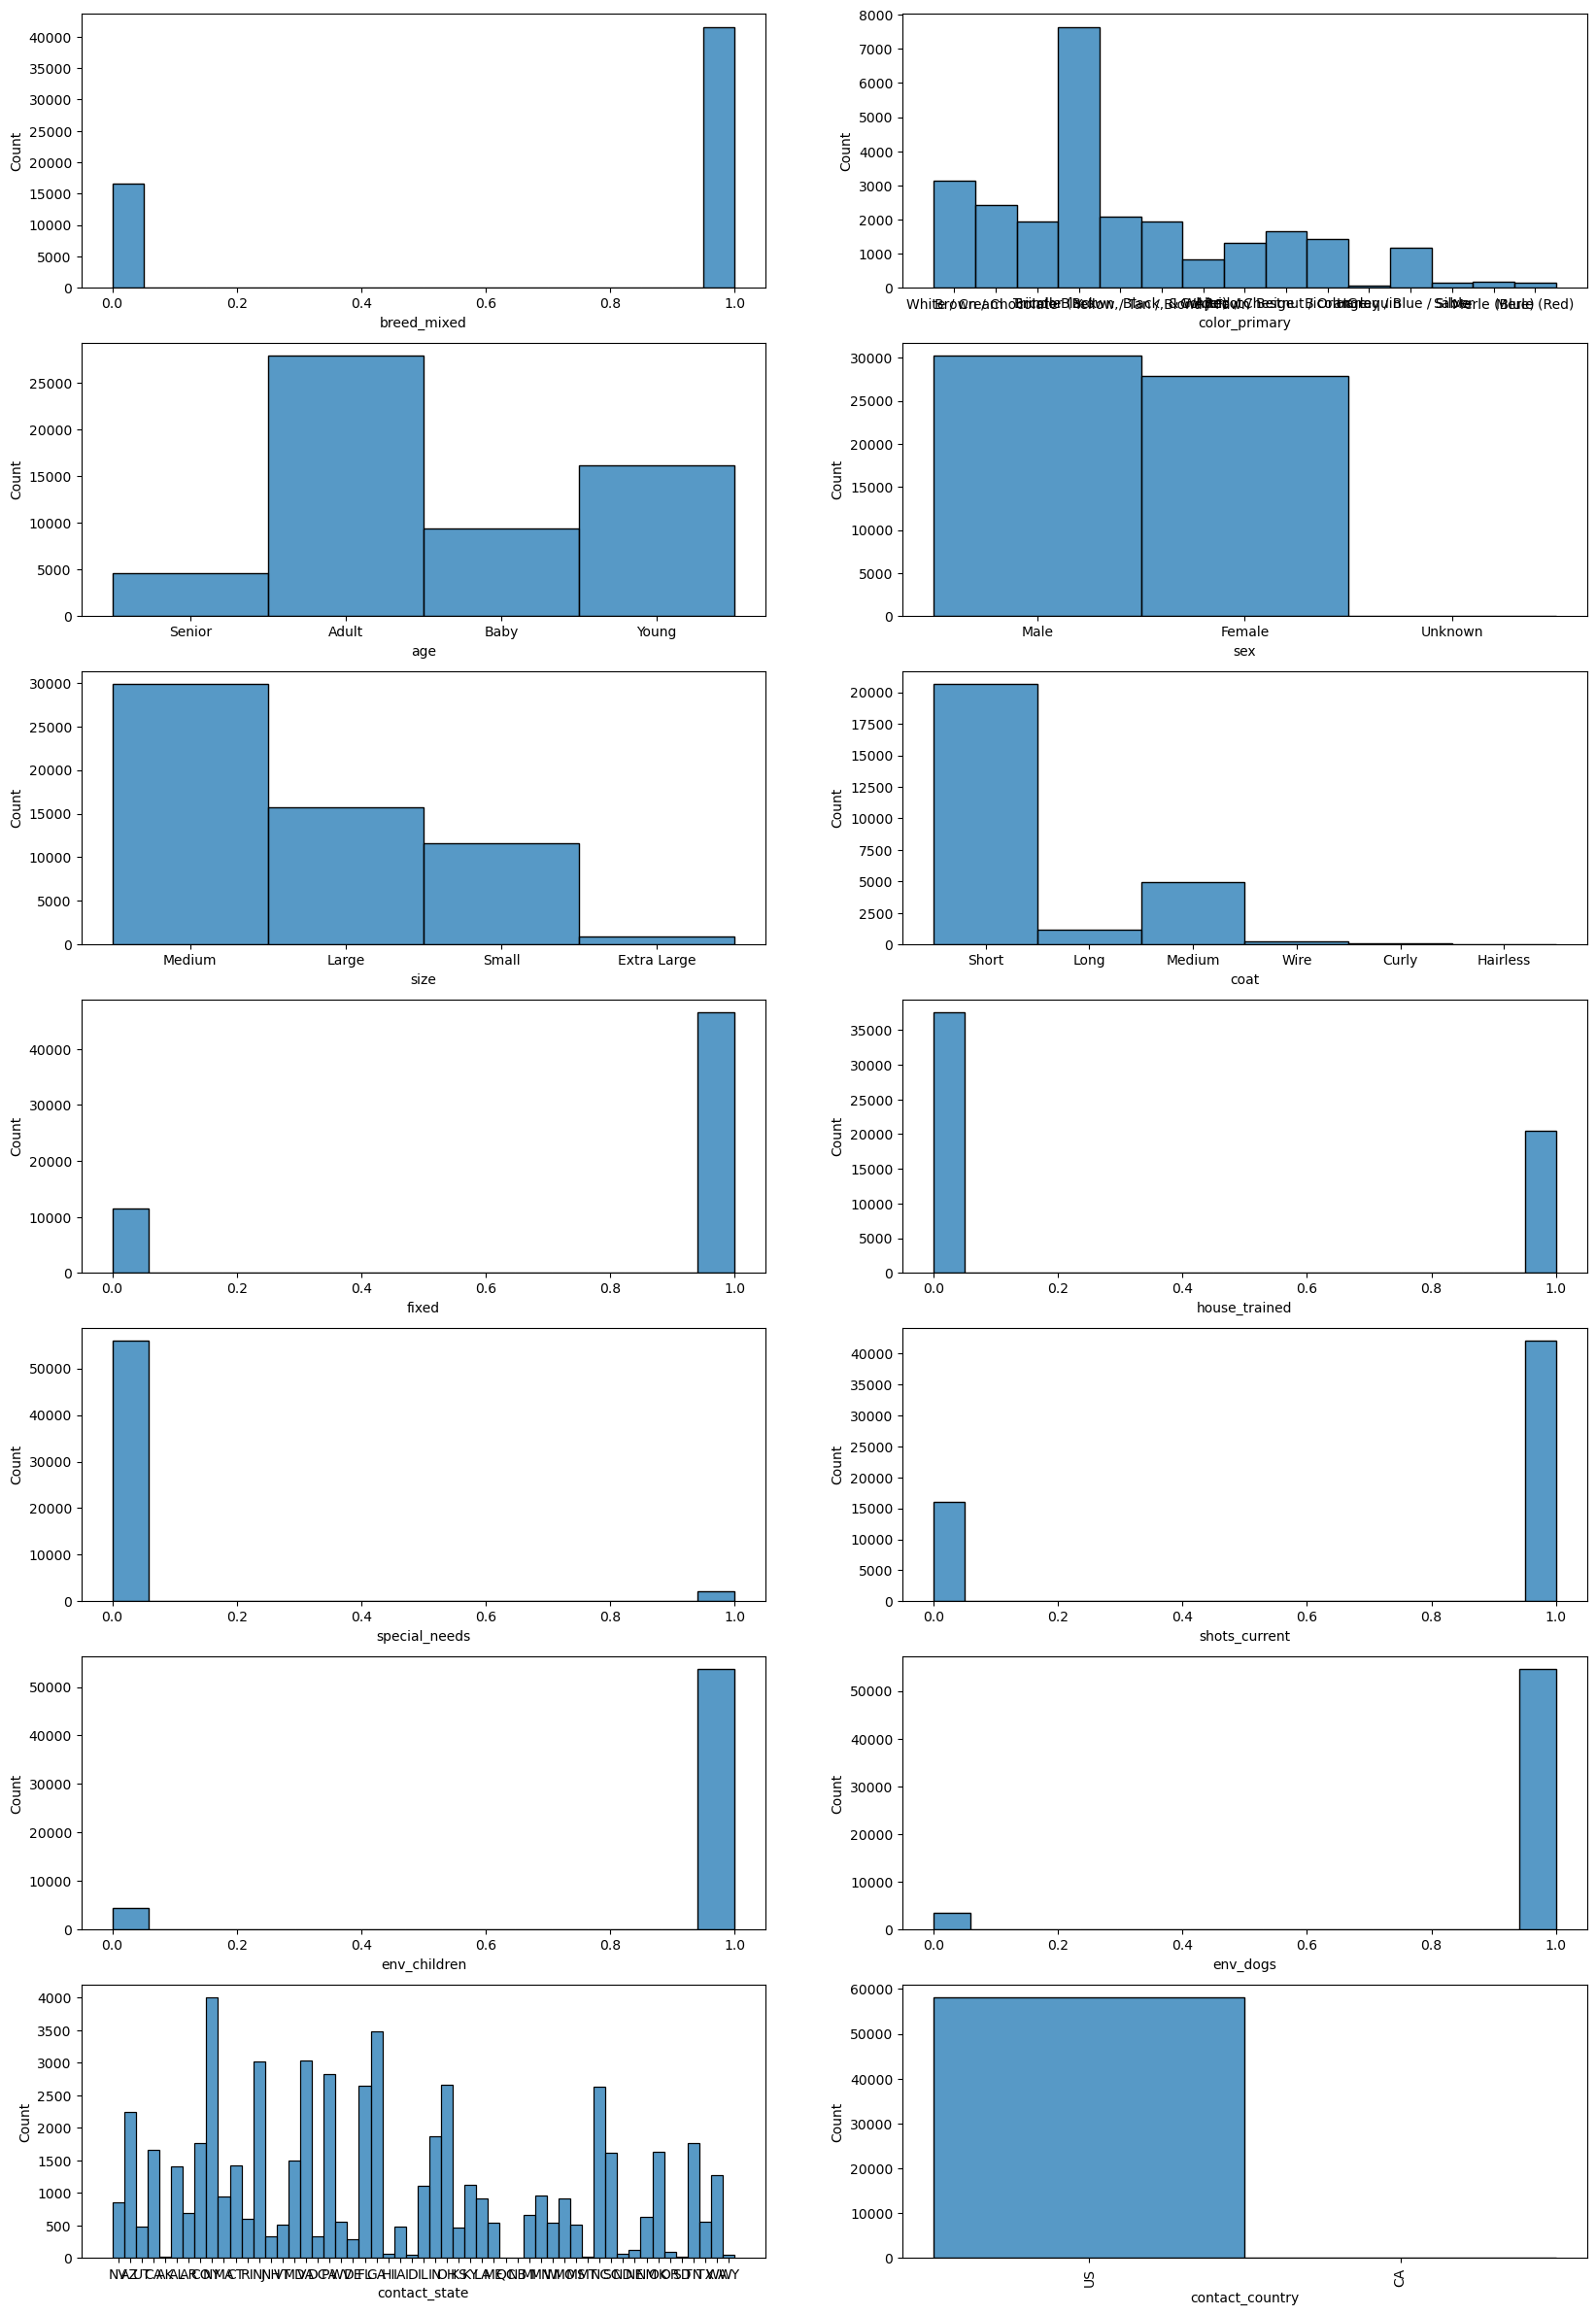

In [206]:
# Histograms of multiple categories

columns = ['breed_mixed', 'color_primary', 'age', 'sex', 'size', 'coat', 'fixed', 'house_trained', 'special_needs', 'shots_current', 'env_children', 'env_dogs', 'contact_state', 'contact_country']
# 14 categories
# excluding ['org_id', 'breed_primary', 'name', 'contact_city', 'contact_zip', 'description']

r = 7
c = 2

fig, axes = plt.subplots(r, c, figsize=(20, 30))

a = 0
for i in range(r):
    for j in range(c):
        sns.histplot(allDogs, x=columns[a], ax=axes[i, j])
        plt.xticks(rotation=90)
        a = a + 1

plt.show()

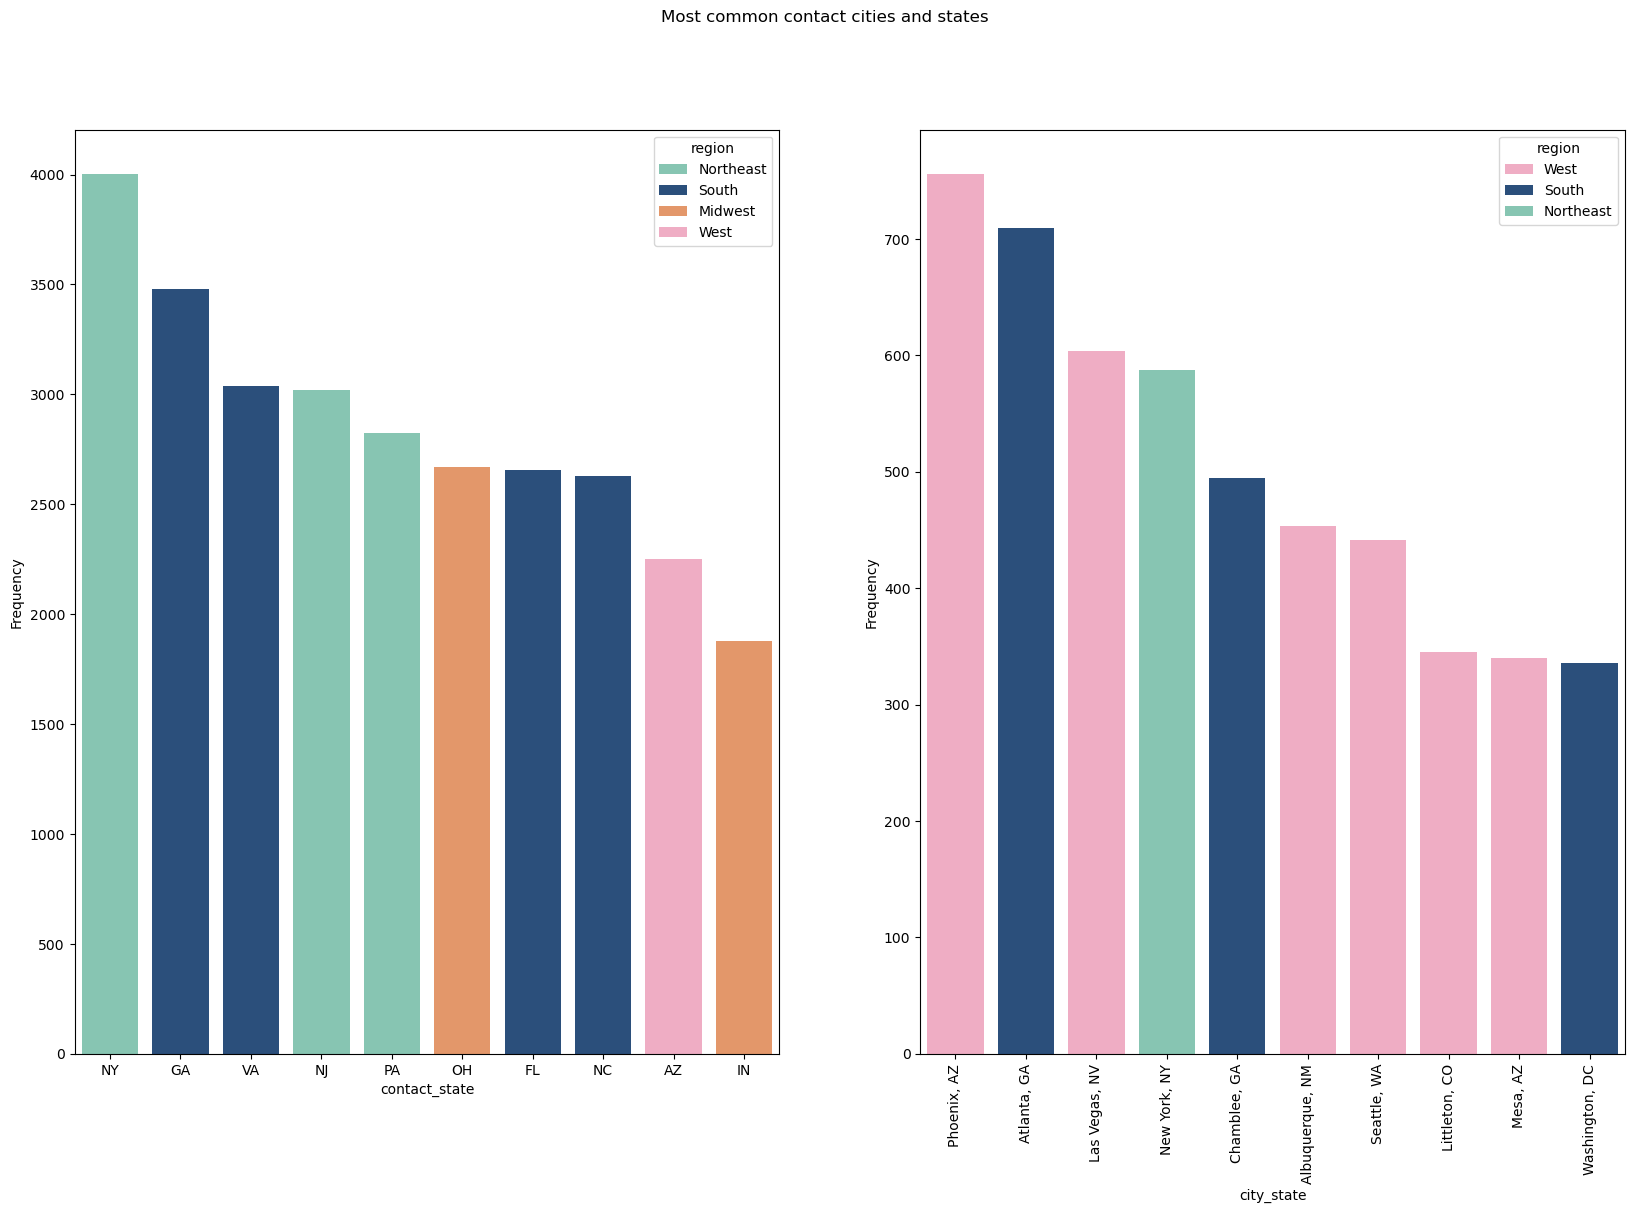

In [207]:
# Top states and cities
pd.set_option("display.max_rows", 10)

most_city_state = allDogs[['contact_city', 'contact_state']].value_counts().head(10)
most_state = allDogs['contact_state'].value_counts().head(10)

most_city_state_df = most_city_state.reset_index(name='Frequency')
most_city_state_df.rename(columns={'index': ['contact_city', 'contact_state']}, inplace=True)
most_city_state_df = most_city_state_df.merge(regions, left_on='contact_state', right_on='state', how='left')
most_city_state_df['city_state'] = most_city_state_df['contact_city'] + ', ' + most_city_state_df['contact_state']

most_state_df = most_state.reset_index(name='Frequency')
most_state_df.rename(columns={'index': 'contact_state'}, inplace=True)
most_state_df = most_state_df.merge(regions, left_on='contact_state', right_on='state', how='left')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))
sns.barplot(data=most_state_df, x='contact_state', y='Frequency', hue='region', palette=region_color_code, ax=ax1)
sns.barplot(data=most_city_state_df, x='city_state', y='Frequency', hue='region', palette=region_color_code, ax=ax2)
plt.xticks(rotation=90)
fig.suptitle("Most common contact cities and states")
plt.show()

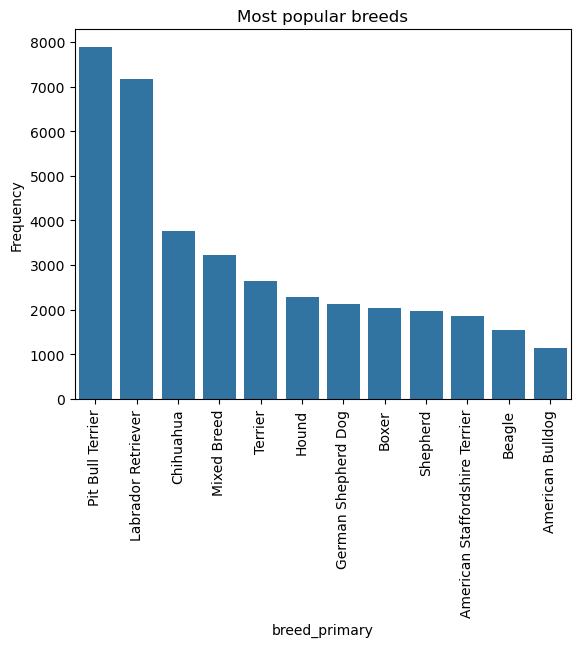

In [208]:
# Top breeds
pd.set_option("display.max_rows", None)
breed_primary = allDogs['breed_primary'].value_counts()

# Three tiers of frequencies
most = breed_primary[breed_primary>=1000]
moderate = breed_primary[(breed_primary>=100) & (breed_primary<1000)]
least = breed_primary[breed_primary<100]

most_df = most.reset_index(name='Frequency')
most_df.rename(columns={'index': 'breed_primary'}, inplace=True)

sns.barplot(data = most_df, x='breed_primary', y='Frequency')
plt.title("Most popular breeds")
plt.xticks(rotation=90)
plt.show()

C:\Users\yenmi\AppData\Local\Temp\ipykernel_17972\1709027778.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')


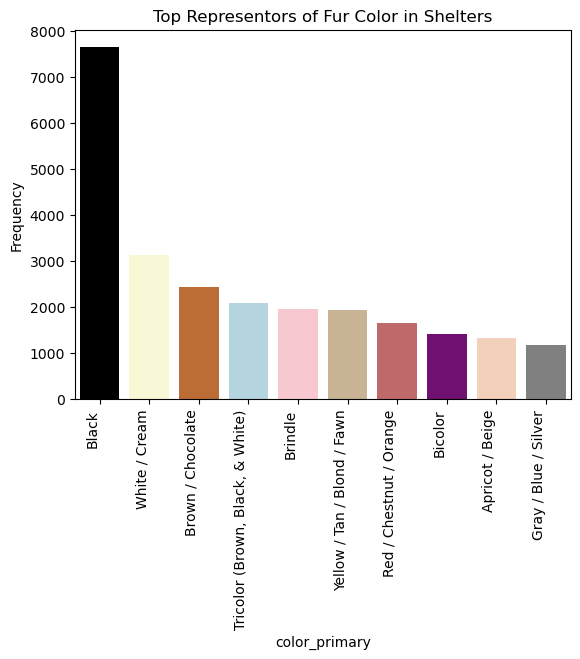

In [209]:
# Fur color
fur = {'Black': 'black',
       'White / Cream': '#fffdd0',
       'Brown / Chocolate': '#d2691e',
       'Tricolor (Brown, Black, & White)': 'lightblue',
       'Brindle': 'pink',
       'Yellow / Tan / Blond / Fawn': '#d2b48c',
       'Red / Chestnut / Orange': '#cd5c5c',
       'Bicolor': 'purple',
       'Apricot / Beige': '#fbceb1',
       'Gray / Blue / Silver': '#808080'}
fur_color = allDogs['color_primary'].value_counts().head(10).reset_index(name='Frequency')
ax = sns.barplot(fur_color, x='color_primary', y='Frequency', hue='color_primary', palette=fur)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')
plt.title("Top Representors of Fur Color in Shelters")
plt.show()

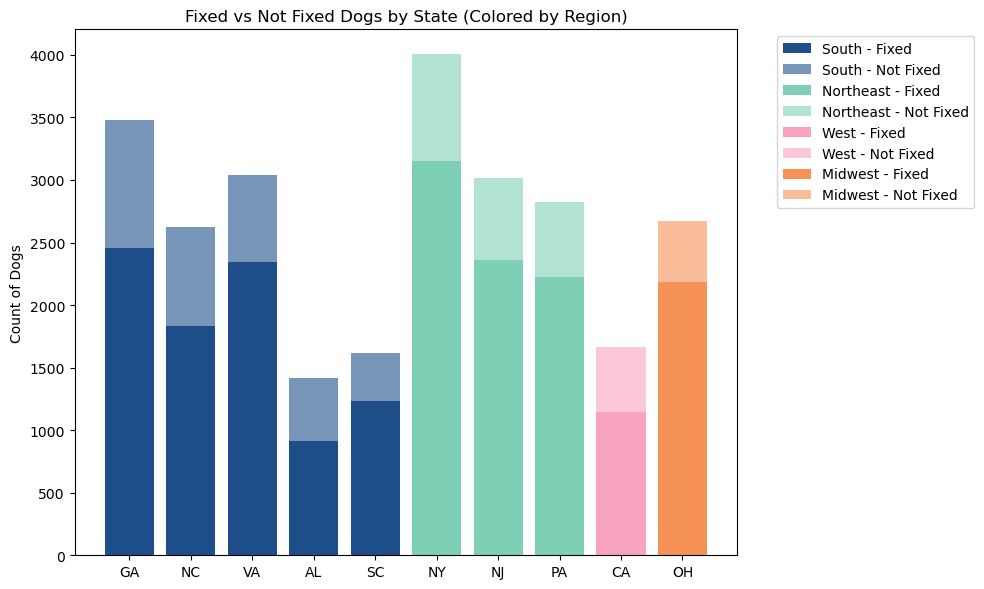

In [210]:
# Neutered and spayed

# Calculate percentage of dogs fixed per state
fixed_true = allDogs.groupby('contact_state').fixed.sum()
total_count = allDogs.groupby('contact_state').fixed.count()
fixed_ratio = fixed_true / total_count * 100

# Merge these Series
fixed_ratio_df = pd.DataFrame({'state': fixed_ratio.index.to_list(), 'Fixed_True': fixed_true, 'Total count': total_count, 'Fixed ratio': fixed_ratio})
fixed_ratio_df['Fixed_False'] = fixed_ratio_df['Total count'] - fixed_ratio_df['Fixed_True']
fixed_ratio_df = fixed_ratio_df.sort_values(by='Fixed ratio').head(10)
fixed_ratio_df = fixed_ratio_df.merge(regions, on='state', how='left')
fixed_ratio_df = fixed_ratio_df[['state', 'region', 'Fixed_True', 'Fixed_False', 'Total count', 'Fixed ratio']]
fixed_ratio_df

# sns.plot(data=df, x='contact_state', hue='fixed', multiple='stack')
# plt.show()

# Plot stacked bar chart of states with highest count of dogs that aren't fixed
# Step 0: Prepare the dataframe
low_ratio_states = fixed_ratio.index.to_list()
df = allDogs[allDogs['contact_state'].isin(low_ratio_states)][['fixed', 'contact_state']]
df = df.merge(regions, left_on='contact_state', right_on='state', how='left')
df.drop('contact_state', axis=1, inplace=True)
df = df[['state', 'region', 'fixed']]
df

# Step 1: Count how many True/False per State
counts = df.groupby(['state', 'region', 'fixed']).size().reset_index(name='count')

# Step 2: Pivot to get stacking
pivot_df = counts.pivot_table(index=['state', 'region'], columns='fixed', values='count', fill_value=0).reset_index()
pivot_df = pivot_df.sort_values(by=False, ascending=False).head(10)
pivot_df

# Step 3: Define colors per region
colors = {'Midwest': '#F79256',
          'Northeast': '#7DCFB6',
          'West': '#FAA2C1',
          'South': '#1D4E89'}

# Step 4: Plotting stacked bars
fig, ax = plt.subplots(figsize=(10, 6))

for region in pivot_df['region'].unique():
    region_data = pivot_df[pivot_df['region'] == region]
    ax.bar(region_data['state'], region_data[True], color=colors[region], label=f'{region} - Fixed')
    ax.bar(region_data['state'], region_data[False], bottom=region_data[True], color=colors[region], alpha=0.6, label=f'{region} - Not Fixed')

# Deduplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_ylabel('Count of Dogs')
ax.set_title('Fixed vs Not Fixed Dogs by State (Colored by Region)')
plt.tight_layout()
plt.show()

**dogTravel**

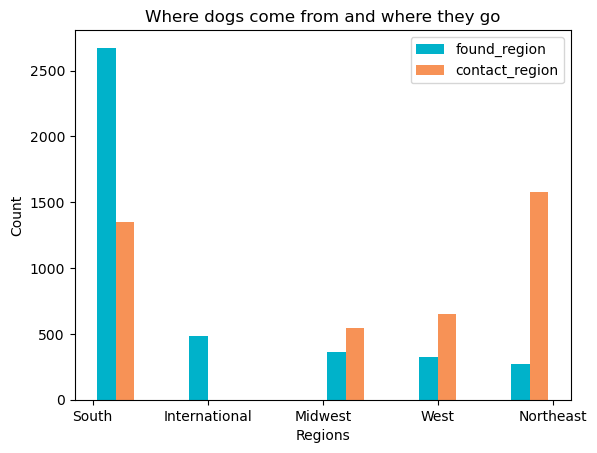

In [212]:
# Movement of dogs by region
plt.hist([dogTravel['found_region'], dogTravel['contact_region']], label=['found_region', 'contact_region'], color=['#00B2CA', '#F79256'])
# plt.figure(figsize=(10,5))
# plt.hist([dogTravel['found_region']], label=['found_region'])
# plt.hist([dogTravel['contact_region']], label=['contact_region'])
plt.xlabel('Regions')
plt.ylabel('Count')
plt.title('Where dogs come from and where they go')
plt.legend(loc='upper right')
plt.show()

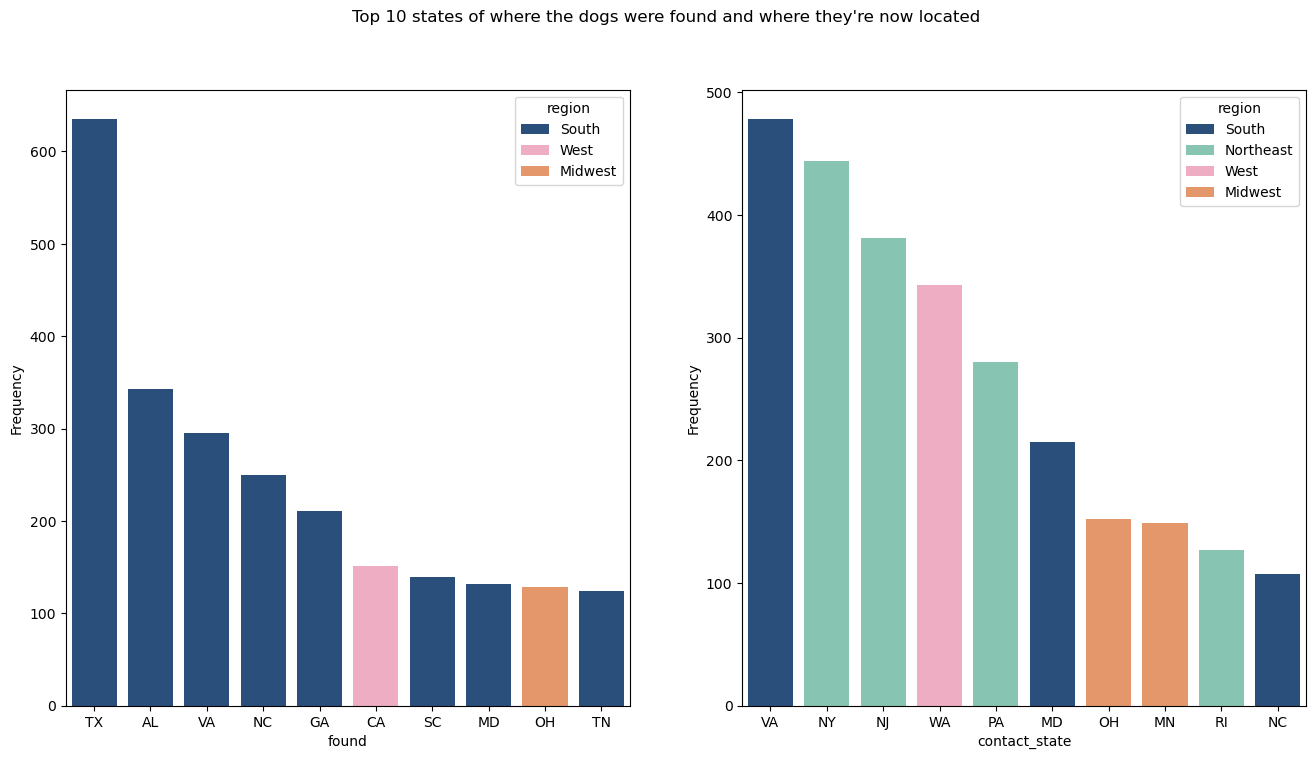

In [213]:
# Top 10 contact states and found states
pd.set_option("display.max_rows", 100)
contact_state = dogTravel['contact_state'].value_counts()
found = dogTravel['found'].value_counts()

most_found_df = found.reset_index(name='Frequency').head(10)
most_found_df.rename(columns={'index': 'found'}, inplace=True)
most_found_df = most_found_df.merge(regions, left_on='found', right_on='state', how='left')

most_state_df = contact_state.reset_index(name='Frequency').head(10)
most_state_df.rename(columns={'index': 'contact_state'}, inplace=True)
most_state_df = most_state_df.merge(regions, left_on='contact_state', right_on='state', how='left')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.barplot(data=most_found_df, x='found', y='Frequency', hue='region', palette=region_color_code, saturation=0.75, ax=ax1)
sns.barplot(data=most_state_df, x='contact_state', y='Frequency', hue='region', palette=region_color_code, saturation=0.75, ax=ax2)
fig.suptitle("Top 10 states of where the dogs were found and where they're now located")
plt.show()

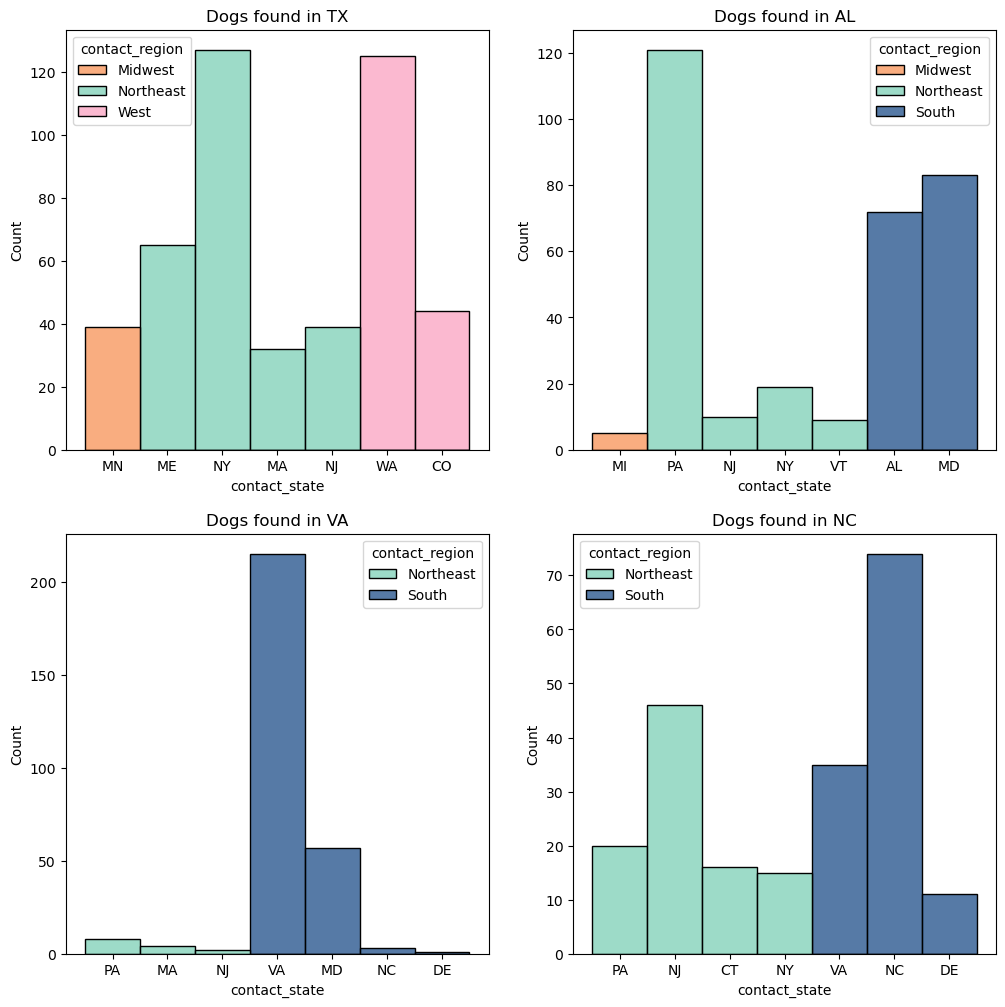

In [214]:
# For the top 4 sources of dogs, look at the top 5 states they get listed
found_states = ['TX', 'AL', 'VA', 'NC']
r, c = 2, 2
a = 0
fig, axes = plt.subplots(r, c, figsize=(12, 12))
for i in range(r):
    for j in range(c):
        sub_dataframe = dogTravel[dogTravel['found']==found_states[a]]
        series = sub_dataframe['contact_state'].value_counts()
        df = series.reset_index(name='Frequency').head(7)
        frequent_states = df['contact_state']
        df = sub_dataframe[sub_dataframe['contact_state'].isin(frequent_states)].sort_values(by='contact_region')
        sns.histplot(df, x='contact_state', hue='contact_region', palette=region_color_code, alpha=0.75, ax=axes[i, j])
        axes[i, j].set_title('Dogs found in ' + found_states[a])
        a = a + 1
plt.show()

**movesByLocation**

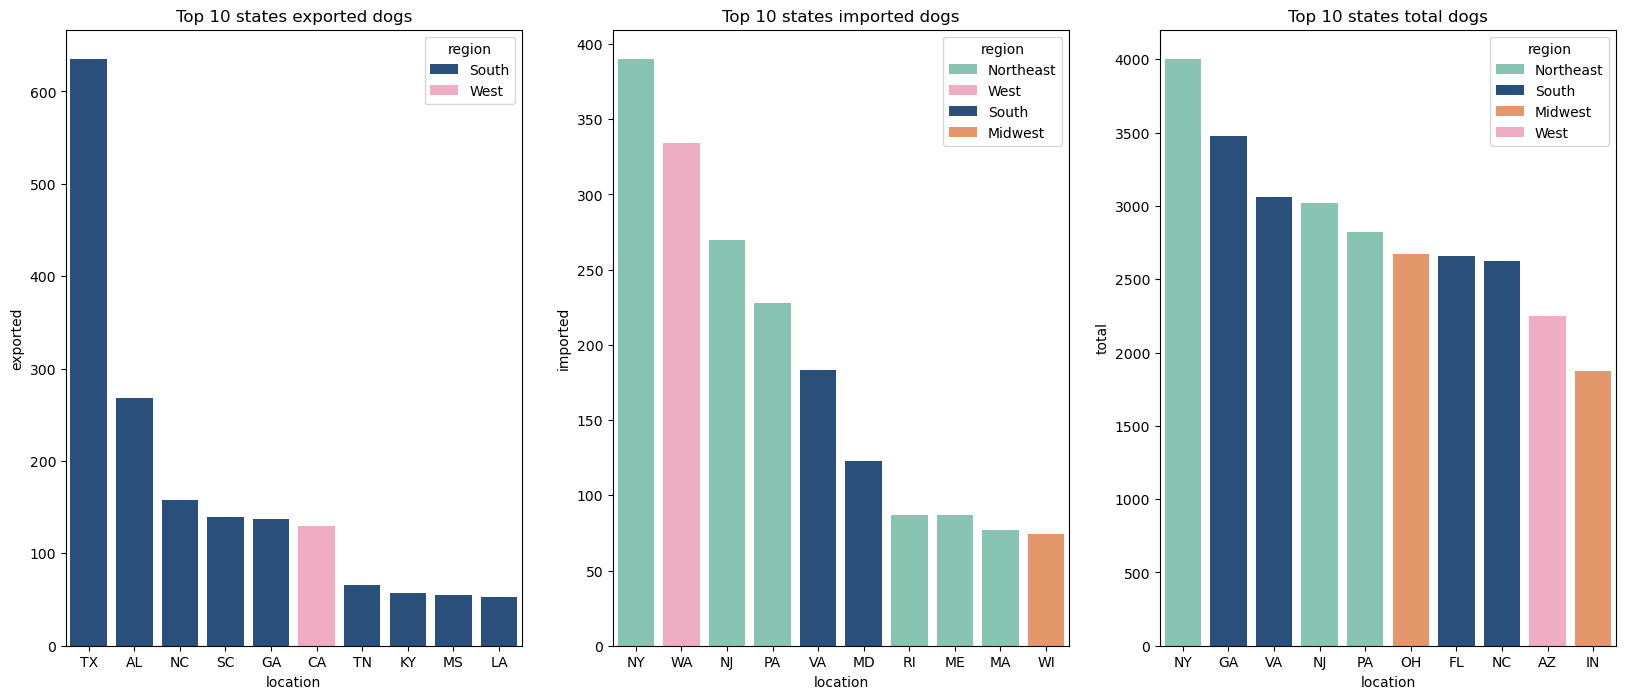

In [216]:
# Top 10 exports, top 10 imports, and top 10 totals within U.S.
USA = movesByLocation[movesByLocation['inUS']]
USA.groupby('region').sum()

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
col = ['exported', 'imported', 'total']
for i in range(3):
    df = USA.sort_values(by=col[i], ascending=False).head(10)
    sns.barplot(data=df, x='location', y=col[i], hue='region', palette=region_color_code, ax=axes[i]).set(title='Top 10 states ' + col[i] + ' dogs')
plt.show()

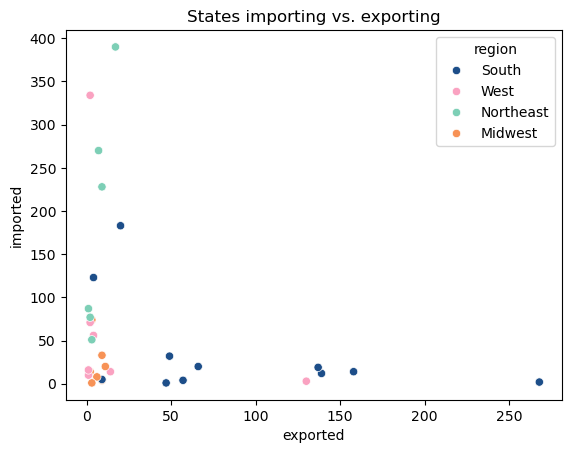

In [217]:
# Scatterplot relationship between exporting and importing
sns.scatterplot(data=USA, x='exported', y='imported', hue='region', palette=region_color_code)
plt.title("States importing vs. exporting")
plt.show()

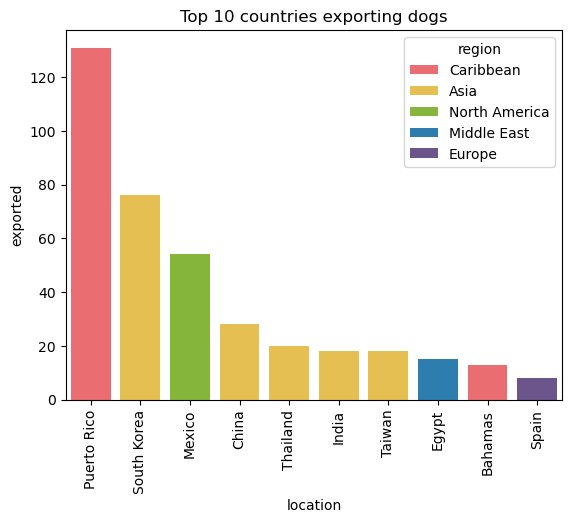

In [218]:
# Top 10 international exports
international = movesByLocation[movesByLocation['inUS']==False]

region_color_code2 = {'Caribbean': '#FF595E',
                     'Asia': '#FFCA3A',
                     'North America': '#8AC926',
                     'Middle East': '#1982C4',
                     'Europe': '#6A4C93'}

df = international.sort_values(by='exported', ascending=False).head(10)
sns.barplot(data=df, x='location', y='exported', hue='region', palette=region_color_code2).set(title='Top 10 countries exporting dogs')
plt.xticks(rotation=90) 
plt.show()

# 3.) Preprocessing the training and testing data

## 3a.) Creating dummy variables

In [221]:
# Create function that returns list of categories to be one-hot encoded
def identify_dummy_categories(df, thresh=10):
    categories = []
    for col in df.columns:
        if df[col].nunique() < thresh:
            categories.append(col)
            print(col + " unique values: " + str(df[col].nunique()))
    return categories

print(identify_dummy_categories(allDogs))
print(identify_dummy_categories(dogTravel))
print(identify_dummy_categories(movesByLocation))

breed_mixed unique values: 2
age unique values: 4
sex unique values: 3
size unique values: 4
coat unique values: 6
fixed unique values: 2
house_trained unique values: 2
special_needs unique values: 2
shots_current unique values: 2
env_children unique values: 2
env_dogs unique values: 2
contact_country unique values: 2
region unique values: 5
['breed_mixed', 'age', 'sex', 'size', 'coat', 'fixed', 'house_trained', 'special_needs', 'shots_current', 'env_children', 'env_dogs', 'contact_country', 'region']
contact_region unique values: 4
found_region unique values: 5
['contact_region', 'found_region']
inUS unique values: 2
['inUS']


**allDogs**

In [223]:
# One-hot encode features. Give categorical code to output variable (allDogs)
features = ['breed_primary', 'breed_mixed', 'age', 'sex', 'size', 'coat', 'fixed', 'house_trained', 'special_needs', 'shots_current', 'env_children', 'env_dogs', 'contact_state']
allDogs = allDogs[features]

# One-hot encode these columns.
allDogs_encoded = pd.get_dummies(allDogs, columns=['age', 'sex', 'size', 'coat', 'contact_state'])

# Turn the 'breed_primary' into a multiclass categorical label
code_dict = {'Pit Bull Terrier': 0, 'Labrador Retriever': 1, 'Chihuahua': 2, 'Mixed Breed': 3, 'Terrier': 4, 
             'Hound': 5, 'German Shepherd Dog': 6, 'Boxer': 7, 'Shepherd': 8, 'American Staffordshire Terrier': 9}
allDogs_encoded['breed_code'] = allDogs_encoded['breed_primary'].map(code_dict)
allDogs_encoded['breed_code'] = allDogs_encoded['breed_code'].fillna(10)
allDogs_encoded.drop('breed_primary', inplace=True, axis=1)

**dogTravel**

In [237]:
# One-hot encode features. Give categorical code to output variable (dogTravel)
dogTravel_encoded = pd.get_dummies(dogTravel, columns=['contact_region'])

# Turn the 'found_region' into a multiclass categorical label
code_dict = {'International': 0, 'Midwest': 1, 'Northeast': 2, 'South': 3, 'West': 4}
dogTravel_encoded['found_code'] = dogTravel['found_region'].map(code_dict)

**movesByLocation**

In [227]:
# One-hot encode features
movesByLocation_encoded = pd.get_dummies(movesByLocation, columns=identify_dummy_categories(movesByLocation, 12))

region unique values: 11
inUS unique values: 2


## 3b.) Standardize values

In [229]:
# Standardize movesByLocation
scaler = StandardScaler()
movesByLocation_scaled = movesByLocation_encoded.copy()
features = ['exported', 'imported', 'total']
movesByLocation_scaled[features] = scaler.fit_transform(movesByLocation_scaled[features])

## 3c.) Split data into train and test sets

**allDogs**

In [232]:
# Split data into training and test sets (allDogs)
X = allDogs_encoded.drop('breed_code', axis=1)
y = allDogs_encoded[['breed_code']]

X_train_allDogs, X_test_allDogs, y_train_allDogs, y_test_allDogs = train_test_split(X, y, test_size=0.3, random_state=42)

**dogTravel**

In [241]:
# Split data into training and test sets (dogTravel)
features = ['contact_region_Midwest', 'contact_region_Northeast', 'contact_region_South', 'contact_region_West']
X = dogTravel_encoded[features]
y = dogTravel_encoded[['found_code']]

X_train_dogTravel, X_test_dogTravel, y_train_dogTravel, y_test_dogTravel = train_test_split(X, y, test_size=0.3, random_state=42)

# 4.) Modeling

In [270]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC # Not sure which model to use yet
from sklearn.model_selection import train_test_split, cross_val_score

## 4a.) Modeling and Evaluating (dogTravel)

In [245]:
X_train = X_train_dogTravel
X_test = X_test_dogTravel
y_train = y_train_dogTravel
y_test = y_test_dogTravel

In [259]:
def EvalMetrics(model, accuracy, precision, recall, f1, roc_auc, cv_score):
    df = pd.DataFrame({'Model': model, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 score': f1, 'ROC_AUC': roc_auc, 'mean CV score': cv_score}, index=[0])
    return df

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.9203840416987658


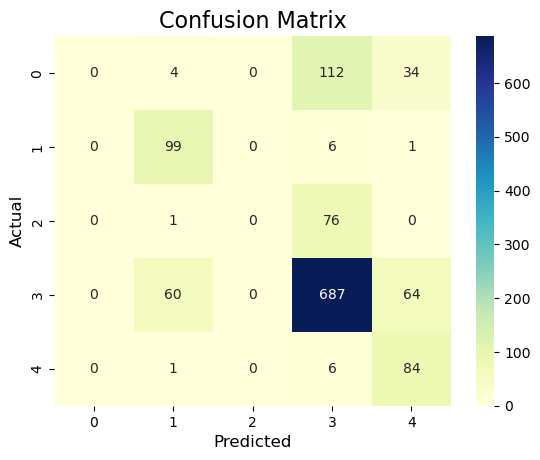

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [260]:
# Logistic Regression: create model and predict
lr = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42) # Initialize the model
lr.fit(X_train, y_train['found_code']) # Train the model
lr_y_predictions = lr.predict(X_test) # Make predictions

# Logistic Regression: evaluate model performance
accuracy = accuracy_score(y_test, lr_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, lr_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(lr, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

lr_df = EvalMetrics('Logistic Regression', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465


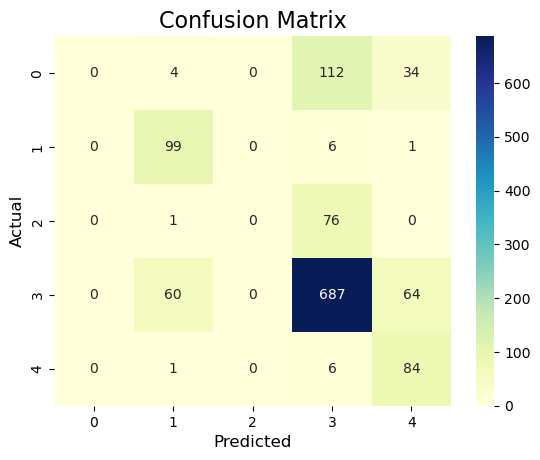

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [261]:
# Support Vector Machine: create model and predict

# svc = LinearSVC() # Create an SVM model
svc = SVC() # Create an SVM model
svc.fit(X_train, y_train['found_code']) # Fit the model to your training data
svc_y_predictions = svc.predict(X_test) # Make predictions

# Support Vector Machine: evaluate model performance
accuracy = accuracy_score(y_test, svc_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
# roc_auc = roc_auc_score(y_test, svc.predict_proba(X_test), average='micro', multi_class='ovr') # Running into error
cm = confusion_matrix(y_test, svc_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
# print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(svc, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

svm_df = EvalMetrics('Support Vector Machine', accuracy, precision, recall, f1, np.nan, cv_scores.mean())

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.920418135029258


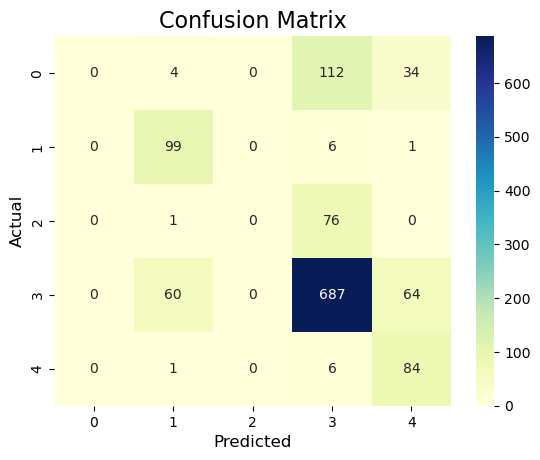

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [272]:
# Decision Tree: create model and predict
dt = DecisionTreeClassifier(random_state=24) # Initialize the Decision Tree classifier
dt.fit(X_train, y_train) # Train the classifier
dt_y_predictions = dt.predict(X_test) # Make predictions on the test set

# Decision Tree: evaluate model performance
accuracy = accuracy_score(y_test, dt_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, dt_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(dt, X, y, cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

dt_df = EvalMetrics('Decision Tree', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.920500417971119


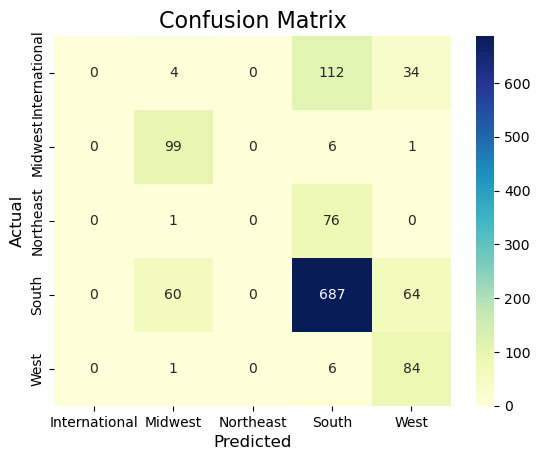

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


In [273]:
# Random Forest: create model and predict

rf = RandomForestClassifier(n_estimators=100, random_state=42) # Create a Random Forest classifier
rf.fit(X_train, y_train['found_code']) # Train the classifier on the training data
rf_y_predictions = rf.predict(X_test) # Make predictions on the test data

# Random Forest: evaluate model performance
accuracy = accuracy_score(y_test, rf_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, rf_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=['International', 'Midwest', 'Northeast', 'South', 'West'], yticklabels=['International', 'Midwest', 'Northeast', 'South', 'West'])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(rf, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

rf_df = EvalMetrics('Random Forest', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())

Accuracy: 0.7044534412955465
Precision: 0.7044534412955465
Recall: 0.7044534412955465
F1-score: 0.7044534412955465
ROC-AUC: 0.8363835663590619


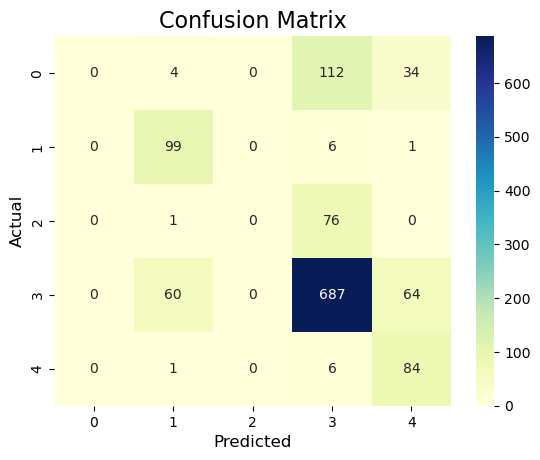

Cross-validation scores: [0.70230863 0.69623329 0.72296476 0.69866343 0.62211422]
Mean cross-validation score: 0.688456865127582


In [274]:
# KNN: create model and predict

knn = KNeighborsClassifier(n_neighbors=3) # Create a kNN model
knn.fit(X_train, y_train['found_code']) # Fit the model to your training data
knn_y_predictions = knn.predict(X_test) # Make predictions

# KNN: evaluate model performance
accuracy = accuracy_score(y_test, knn_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, knn_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# KNN: cross-validation
cv_scores = cross_val_score(knn, X, y['found_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

knn_df = EvalMetrics('K-Nearest Neighbors', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())

In [275]:
# dogTravel Evaluation Metrics Summary Table
dogTravel_evaluationMetrics_df = pd.concat([lr_df, svm_df, dt_df, rf_df, knn_df], ignore_index=True)
dogTravel_evaluationMetrics_df

,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Logistic Regression,0.704453,0.704453,0.704453,0.704453,0.920384,0.706926
1,Support Vector Machine,0.704453,0.704453,0.704453,0.704453,NaN,0.706926
2,Decision Tree,0.704453,0.704453,0.704453,0.704453,0.920418,0.706926
3,Random Forest,0.704453,0.704453,0.704453,0.704453,0.920500,0.706926
4,K-Nearest Neighbors,0.704453,0.704453,0.704453,0.704453,0.836384,0.688457


## 4b.) Modeling and Evaluating (allDogs)

In [277]:
X_train = X_train_allDogs
X_test = X_test_allDogs
y_train = y_train_allDogs
y_test = y_test_allDogs

Accuracy: 0.4188034188034188
Precision: 0.4188034188034188
Recall: 0.4188034188034188
F1-score: 0.4188034188034188
ROC-AUC: 0.8498128230540376


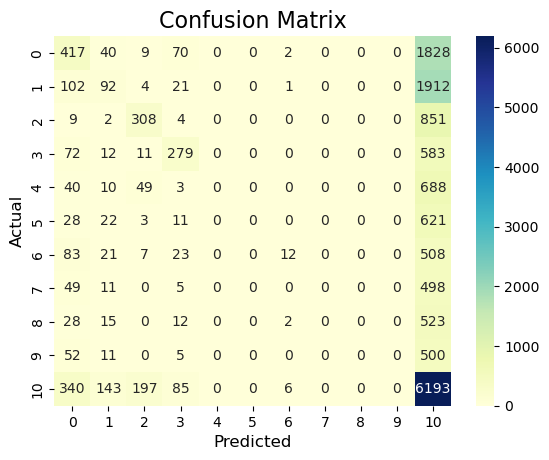

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yenmi\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Logistic Regression,0.418803,0.418803,0.418803,0.418803,0.849813,0.706926


In [284]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear', multi_class='ovr', random_state=42) # Initialize the model
lr.fit(X_train, y_train['breed_code']) # Train the model
lr_y_predictions = lr.predict(X_test) # Make predictions

# Logistic Regression: evaluate model performance
accuracy = accuracy_score(y_test, lr_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, lr_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, lr_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(lr, X, y['breed_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

lr_df = EvalMetrics('Logistic Regression', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
lr_df

In [ ]:
# Support Vector Machine
# # svc = LinearSVC() # Create an SVM model
# svc = SVC() # Create an SVM model
# svc.fit(X_train, y_train['breed_code']) # Fit the model to your training data
# svc_y_predictions = svc.predict(X_test) # Make predictions

# # Support Vector Machine: evaluate model performance
# accuracy = accuracy_score(y_test, svc_y_predictions) # percentage of y_pred that matches y_test
# precision = precision_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
# recall = recall_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
# f1 = f1_score(y_test, svc_y_predictions, average='micro', zero_division=np.nan)
# # roc_auc = roc_auc_score(y_test, svc.predict_proba(X_test), average='micro', multi_class='ovr') # Running into error
# cm = confusion_matrix(y_test, svc_y_predictions)

# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-score: {f1}")
# print(f"ROC-AUC: {roc_auc}")

# # Plot the confusion matrix
# sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
# plt.xlabel('Predicted', fontsize=12)
# plt.ylabel('Actual', fontsize=12)
# plt.title('Confusion Matrix',fontsize=16)
# plt.show()

# # Cross-validation
# cv_scores = cross_val_score(svc, X, y['breed_code'], cv=5) # 5-fold cross-validation
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Mean cross-validation score: {cv_scores.mean()}")

# svm_df = EvalMetrics('Support Vector Machine', accuracy, precision, recall, f1, np.nan, cv_scores.mean())
# svm_df

Accuracy: 0.3892043824929731
Precision: 0.3892043824929731
Recall: 0.3892043824929731
F1-score: 0.3892043824929731
ROC-AUC: 0.7481914251779087


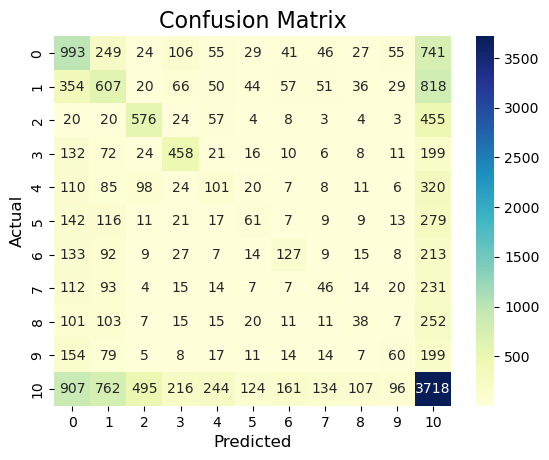

Cross-validation scores: [0.7691373  0.71202916 0.7326853  0.69866343 0.62211422]
Mean cross-validation score: 0.7069258809234508


,Model,Accuracy,Precision,Recall,F1 score,ROC_AUC,mean CV score
0,Decision Tree,0.389204,0.389204,0.389204,0.389204,0.748191,0.706926


In [286]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=24) # Initialize the Decision Tree classifier
dt.fit(X_train, y_train) # Train the classifier
dt_y_predictions = dt.predict(X_test) # Make predictions on the test set

# Decision Tree: evaluate model performance
accuracy = accuracy_score(y_test, dt_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, dt_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, dt_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(dt, X, y, cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
dt_df = EvalMetrics('Decision Tree', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
dt_df

Accuracy: 0.4186886938564791
Precision: 0.4186886938564791
Recall: 0.4186886938564791
F1-score: 0.4186886938564791
ROC-AUC: 0.8236179693619241


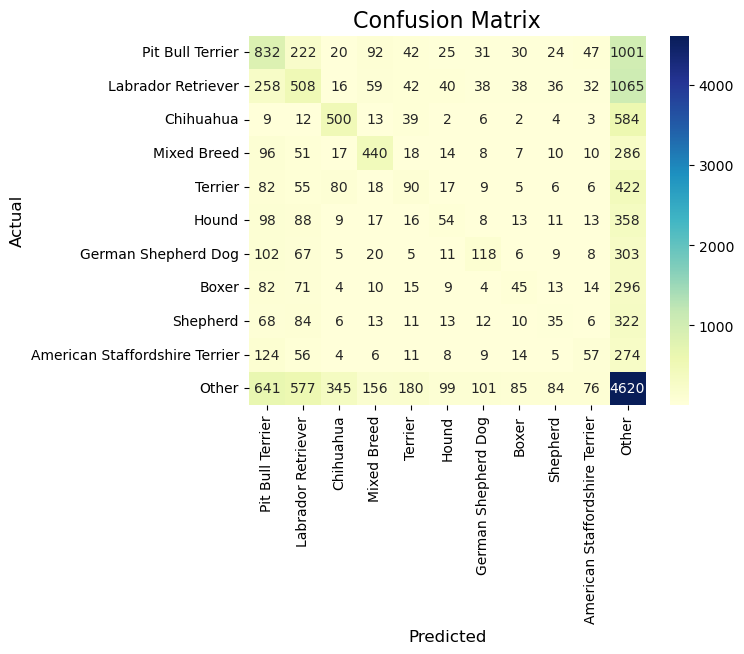

KeyError: 'breed_code'

In [288]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42) # Create a Random Forest classifier
rf.fit(X_train, y_train['breed_code']) # Train the classifier on the training data
rf_y_predictions = rf.predict(X_test) # Make predictions on the test data

# Random Forest: evaluate model performance
accuracy = accuracy_score(y_test, rf_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, rf_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, rf_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
ticklabels = ['Pit Bull Terrier', 'Labrador Retriever', 'Chihuahua', 'Mixed Breed', 'Terrier', 'Hound', 'German Shepherd Dog', 'Boxer', 'Shepherd', 'American Staffordshire Terrier', 'Other']
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=ticklabels, yticklabels=ticklabels)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(rf, X, y['breed_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
rf_df = EvalMetrics('Random Forest', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
rf_df

In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3) # Create a kNN model
knn.fit(X_train, y_train['breed_code']) # Fit the model to your training data
knn_y_predictions = knn.predict(X_test) # Make predictions

# KNN: evaluate model performance
accuracy = accuracy_score(y_test, knn_y_predictions) # percentage of y_pred that matches y_test
precision = precision_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan) # percentage of tp/(tp+fp)
recall = recall_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
f1 = f1_score(y_test, knn_y_predictions, average='micro', zero_division=np.nan)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test), average='micro', multi_class='ovr')
cm = confusion_matrix(y_test, knn_y_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"ROC-AUC: {roc_auc}")

# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=list(range(11)), yticklabels=list(range(11)))
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Cross-validation
cv_scores = cross_val_score(knn, X, y['breed_code'], cv=5) # 5-fold cross-validation
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")
knn_df = EvalMetrics('K-Nearest Neighbors', accuracy, precision, recall, f1, roc_auc, cv_scores.mean())
knn_df

In [ ]:
allDogs_evaluationMetrics_df = pd.concat([lr_df, dt_df, rf_df, knn_df], ignore_index=True)
allDogs_evaluationMetrics_df